In [1]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import mne

In [4]:
import pandas as pd

In [5]:
from scipy.io import loadmat

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [11]:
from sklearn.svm import SVC

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
import plotly.express as px

In [15]:
from sklearn.decomposition import PCA

In [16]:
from scipy.signal import argrelextrema

In [17]:
from scipy.io import loadmat, savemat

In [18]:
from tqdm import tqdm_notebook

In [19]:
MAIN_CHANNELS = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [20]:
sfreq = 250

# Preprocess

In [198]:
def load_data(subject):
    channels = MAIN_CHANNELS
    
    session = loadmat('/tmp/{}.mat'.format(subject))

    session_df = pd.DataFrame(session["y"], columns=channels)

    sfreq = session["fs"][0][0]

    session_df["Time"] = session_df.index / session["fs"][0][0]

    session_df["Trigger"] = session["trig"]
    session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2
    
    return session_df

In [199]:
def restore_raw(session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    info = mne.create_info(ch_names=channels, sfreq=sfreq)

    raw = mne.io.RawArray(session_df[channels].values.T, info)

    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [200]:
def filter_signal(raw):
    raw.notch_filter(50)
    raw.filter(0.5, 30)

In [201]:
def plot_raw(raw, start=30, stop=50, scale=100):
    rcParams['figure.figsize'] = 15, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=9,
        scalings={'eeg': scale}
    )
    plt.show()

In [202]:
#TODO replace with dynamic size !!!!!!!!!

def get_events(raw, min_duration=201):
    events = mne.find_events(raw, 'Trigger')

    non_overlapping_events = [events[0]]
    for event in events[1:]:
        previous_event = non_overlapping_events[-1]
        # If previous event is negative, or events are not overlapping
        if (previous_event[-1] == 2) or (event[0] - previous_event[0] > min_duration):
            non_overlapping_events.append(event)
            
    return np.array(non_overlapping_events)

In [257]:
#TODO replace with dynamic size !!!!!!!!!

def reject_bad_events(raw, events, duration=201):
    new_events = []
    
    for type in [1, 2]:
        type_events = [event for event in events if event[-1] == type]
        total_data = [raw[:8, event[0]:event[0] + duration][0] for event in type_events]
        total_mean = np.mean(total_data)
        total_std = np.std(total_data)

        for index, event_data in enumerate(total_data):
            bad = False
            
            for channel in range(0, 8):
                channel_event_data = event_data[channel]
                channel_event_mean = channel_event_data.mean()
                if np.abs(channel_event_mean - total_mean) >= total_std:
                    bad = True
                    break
            
            if not bad:
                new_events.append(index)
    return np.array([e for i, e in enumerate(events) if i in new_events])

In [258]:
def scale_signal(raw, events, session_df):
    channels = MAIN_CHANNELS + ['Trigger']
    
    channels_data = raw.copy().pick_types(eeg=True).get_data()
    training_data = channels_data[:, (events[0][0] // 2):events[0][0] - 1]

    trigger_data = session_df["Trigger"].values

    scaler = StandardScaler()
    scaler.fit(training_data.T)
    scaled_channels_data = scaler.transform(channels_data.T).T

    np.mean(scaled_channels_data, axis=1)

    new_channels_data = np.vstack([
        scaled_channels_data,
        trigger_data[np.newaxis, :]
    ])

    raw = mne.io.RawArray(new_channels_data, raw.info)
    
    channel_types = {c: 'eeg' for c in channels}
    channel_types['Trigger'] = 'stim'

    raw.set_channel_types(channel_types)
    
    return raw

In [259]:
def remove_artifacts(raw, n_components=2):
    print("Removing artifacts with {}".format(n_components))
    ica = mne.preprocessing.ICA()

    ica.fit(raw)

    ica_eeg = ica.get_sources(raw)

    plt.figure(figsize=(10, 5))
    plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

    stds = np.std(np.abs(ica_eeg[:, :][0]), axis=1)
    exclude_components = (-stds).argsort()[0:n_components + 1]

    raw = ica.apply(raw.copy(), exclude=list(exclude_components))
    
    return raw

In [260]:
def get_epochs(raw, events):
    raw = raw.copy()
    
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
        reject_by_annotation=True,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs

In [261]:
def show_p300_plots(epochs):
    epochs['1'].average().plot()
    plt.show()
    
    epochs['2'].average().plot()
    plt.show()

In [262]:
def process_signal(i, n_components=2, start=30, stop=50):
    subject = "S{}".format(i)
    session_df = load_data(subject)
    raw = restore_raw(session_df)
    
    events = get_events(raw)
    
    plot_raw(raw, start=start, stop=stop)
    
    filter_signal(raw)
    plot_raw(raw, start=start, stop=stop)
    
    raw = scale_signal(raw, events, session_df)
    plot_raw(raw, scale=10, start=start, stop=stop)
    
    events = reject_bad_events(raw, events)
    
#     raw = remove_artifacts(raw, n_components)
    
    epochs = get_epochs(raw, events)    
#     show_p300_plots(epochs)

    return epochs

# Simple classification

In [263]:
from sklearn.model_selection import TimeSeriesSplit

In [264]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [265]:
def get_dataset(i):
    epochs = process_signal(i)
    epochs = epochs.decimate(12)
    
    events_X = epochs.get_data()
    events_X = events_X.reshape(events_X.shape[0], -1)
    
    events_y = epochs.events.T[-1]
    
    return np.vstack(events_X), (events_y == 1).astype(int)

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
2700 events found
Event IDs: [1 2]


<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



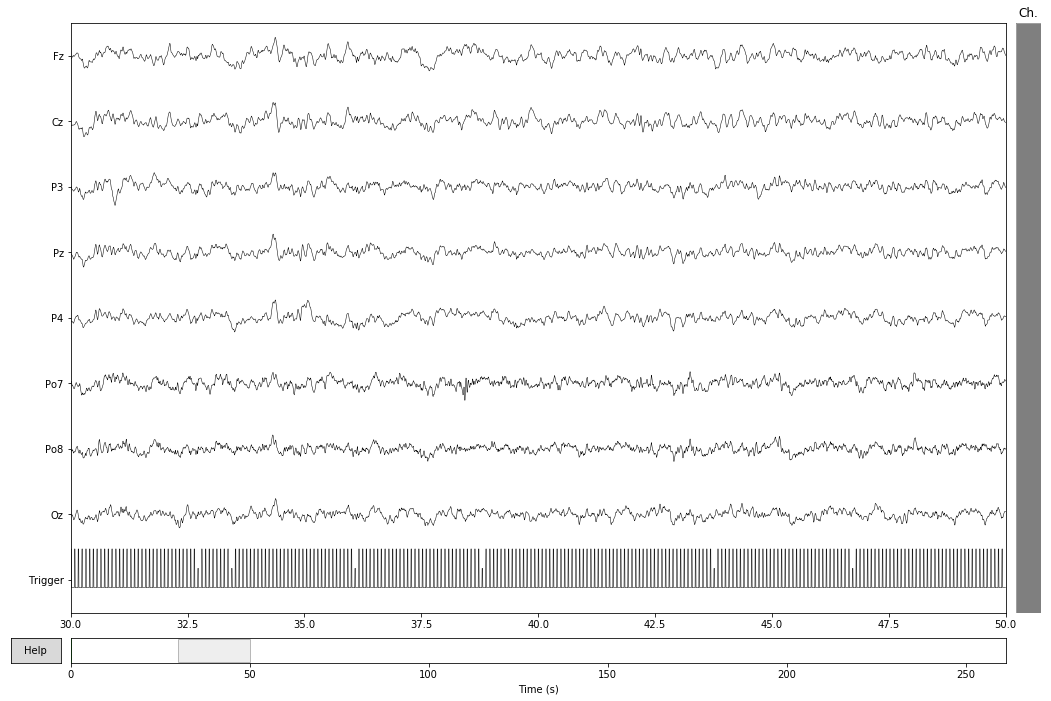

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


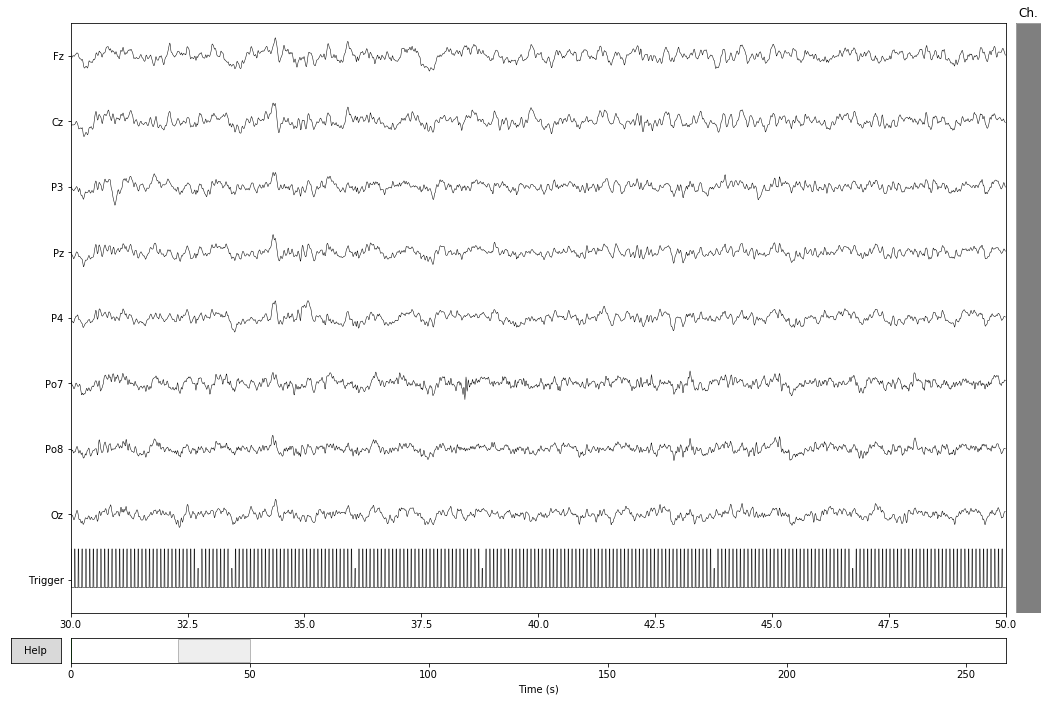

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.


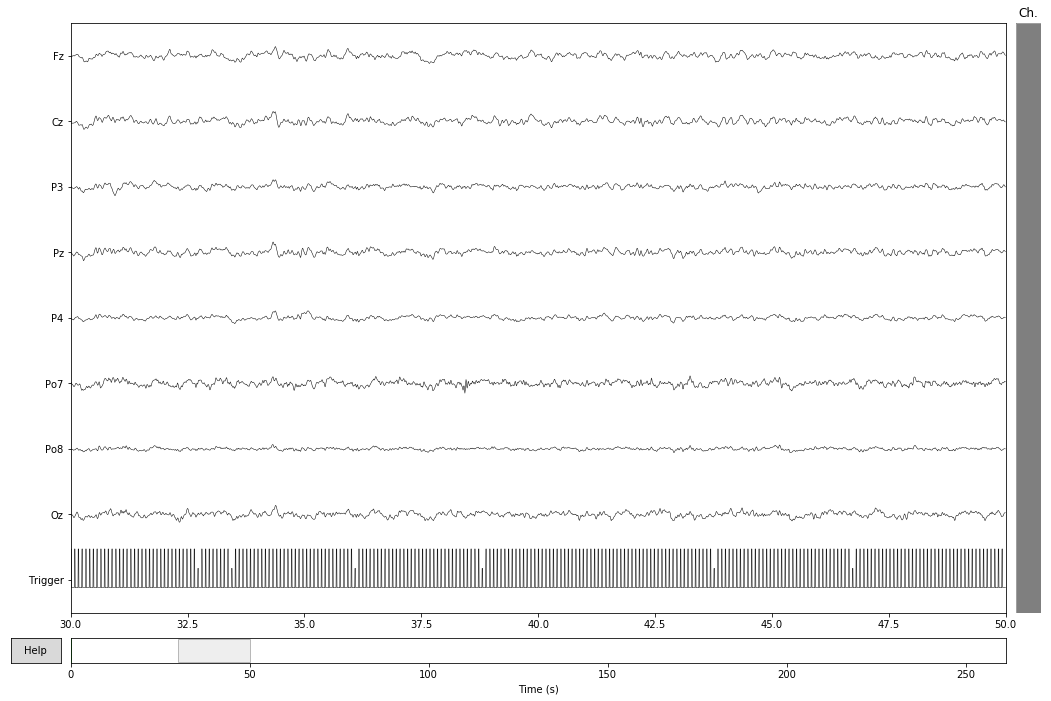

1866 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1866 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



In [266]:
events_X, events_y = get_dataset(1)

In [268]:
grid = {
    "solver": ['svd']
}

In [269]:
def get_scores(events_X, events_y, window_size=15):
    all_indices = np.arange(events_y.shape[0])
    time = np.linspace(-100, 700, events_X.shape[-1] // 8)
    
    scores = []
    
    positive_events_indices = np.nonzero(events_y == 1)[0]

    for i in range(0, len(positive_events_indices), window_size):
        positive_window = positive_events_indices[i:i + window_size]
        window_start = positive_window.min()
        window_end = positive_window.max()
        chosen_indices = (all_indices < window_start) | (all_indices > window_end)
        included_events_X = events_X[chosen_indices]
        included_events_y = events_y[chosen_indices]

        model = LDA()
        model.fit(included_events_X, included_events_y)

        excluded_y = events_y[~chosen_indices]
        excluded_X = events_X[~chosen_indices]
        excluded_predictions = model.predict_proba(excluded_X).T[1]
        roc_auc = roc_auc_score(excluded_y, excluded_predictions)
        scores.append(roc_auc)
    return scores

In [270]:
scores = get_scores(events_X, events_y)

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
2700 events found
Event IDs: [1 2]


<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



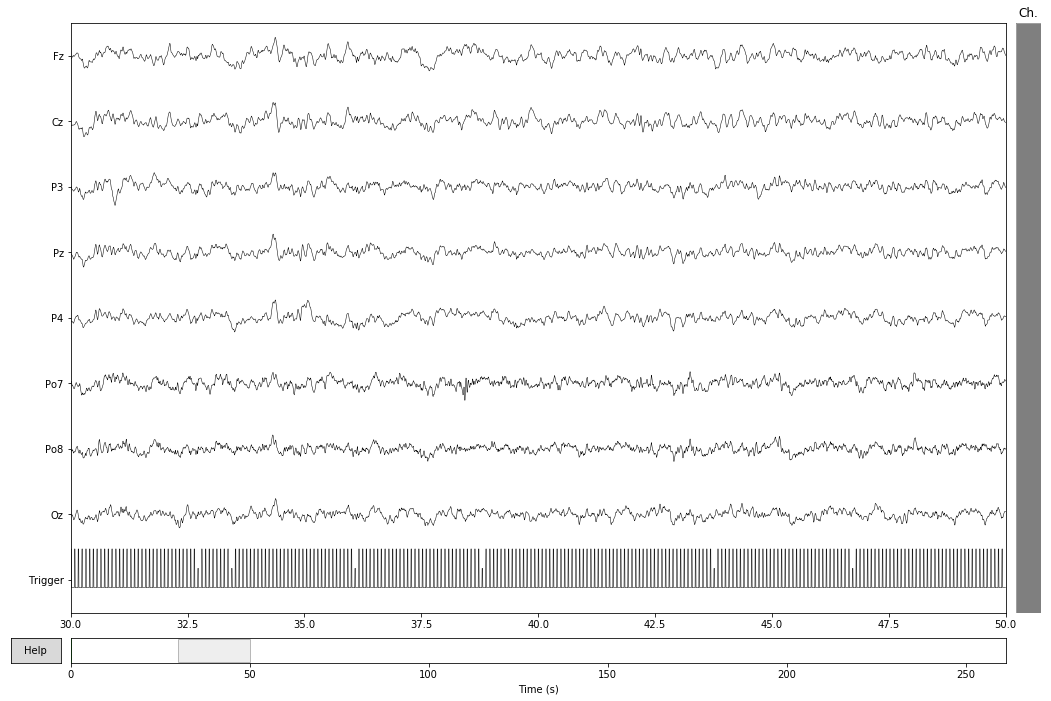

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


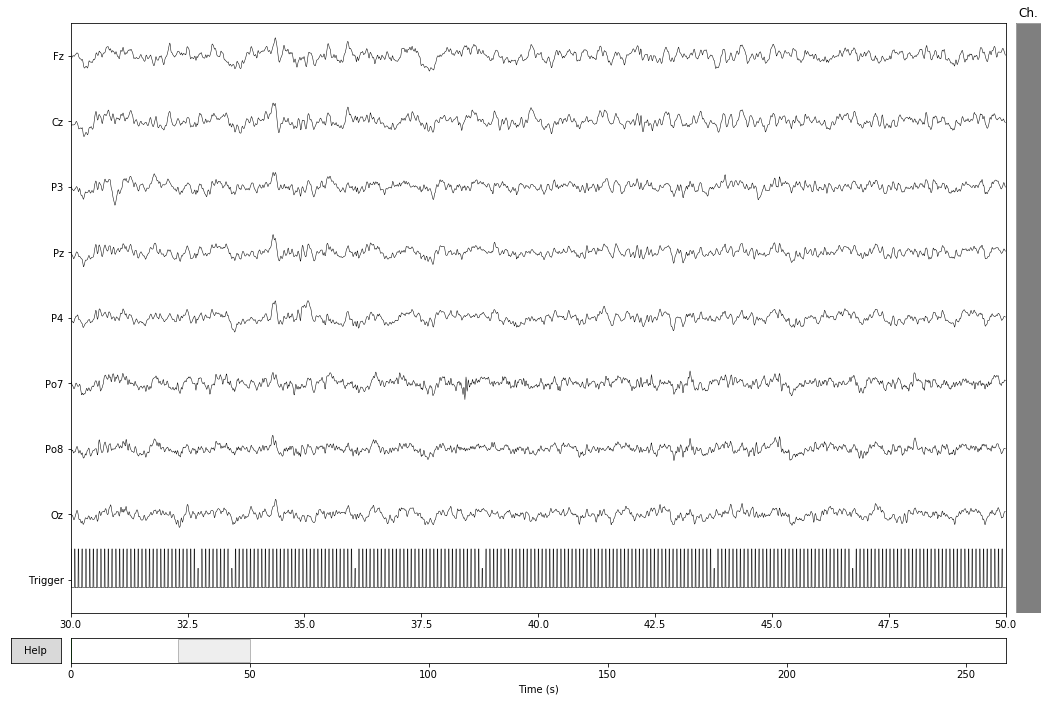

Creating RawArray with float64 data, n_channels=9, n_times=65282
    Range : 0 ... 65281 =      0.000 ...   261.124 secs
Ready.


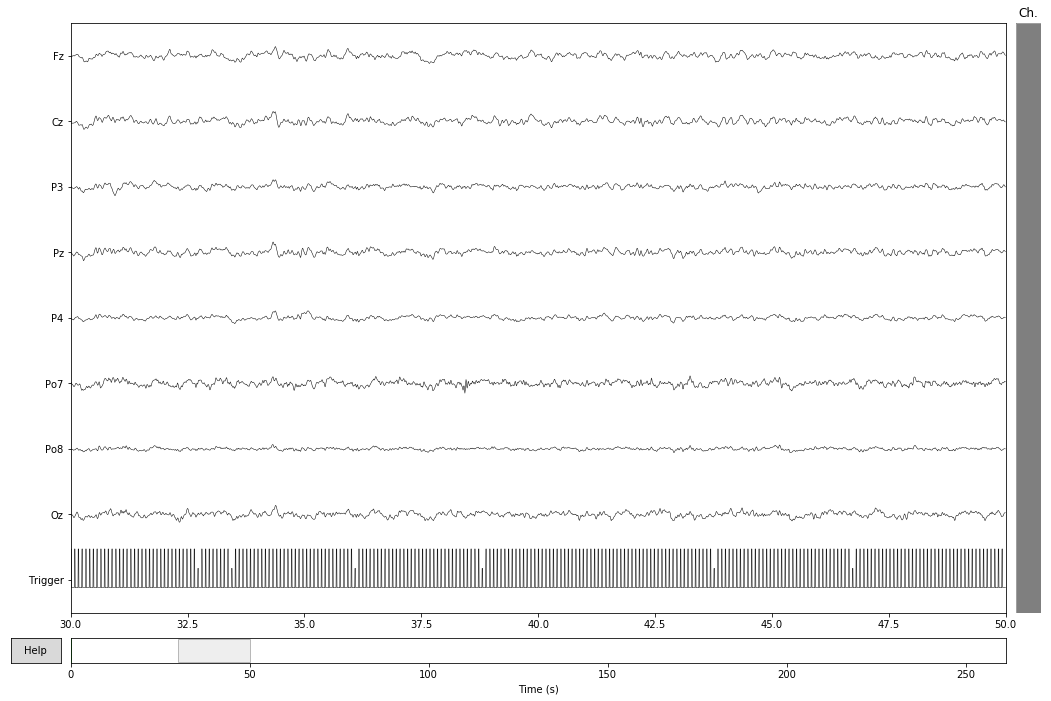

1866 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1866 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
2700 events found
Event IDs: [1 2]


<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



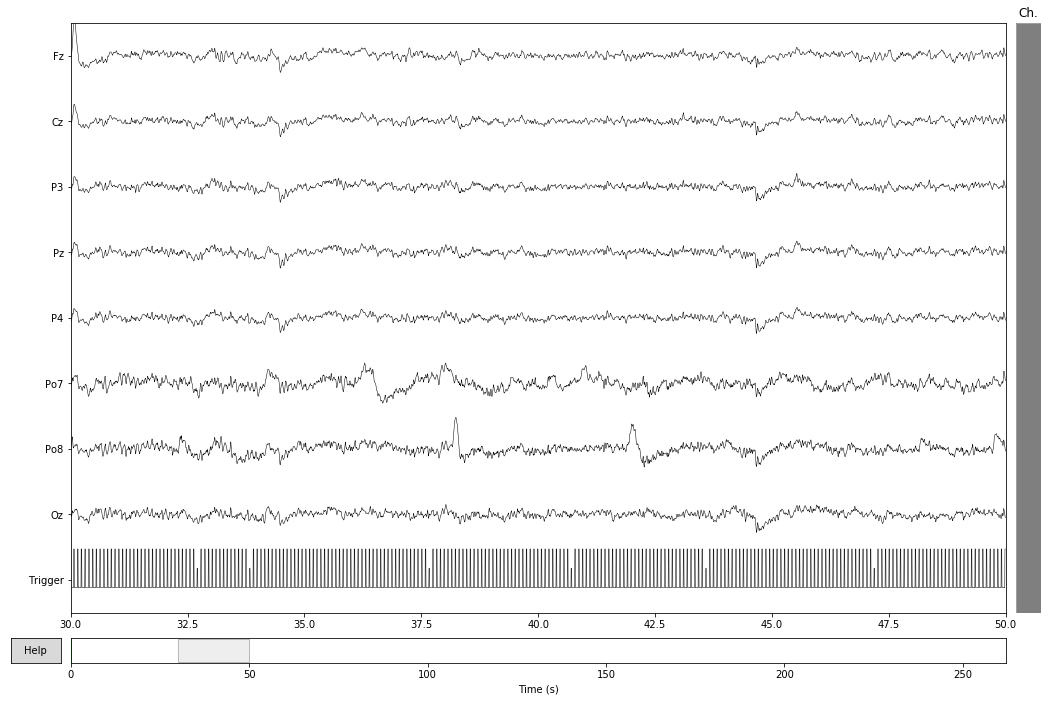

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


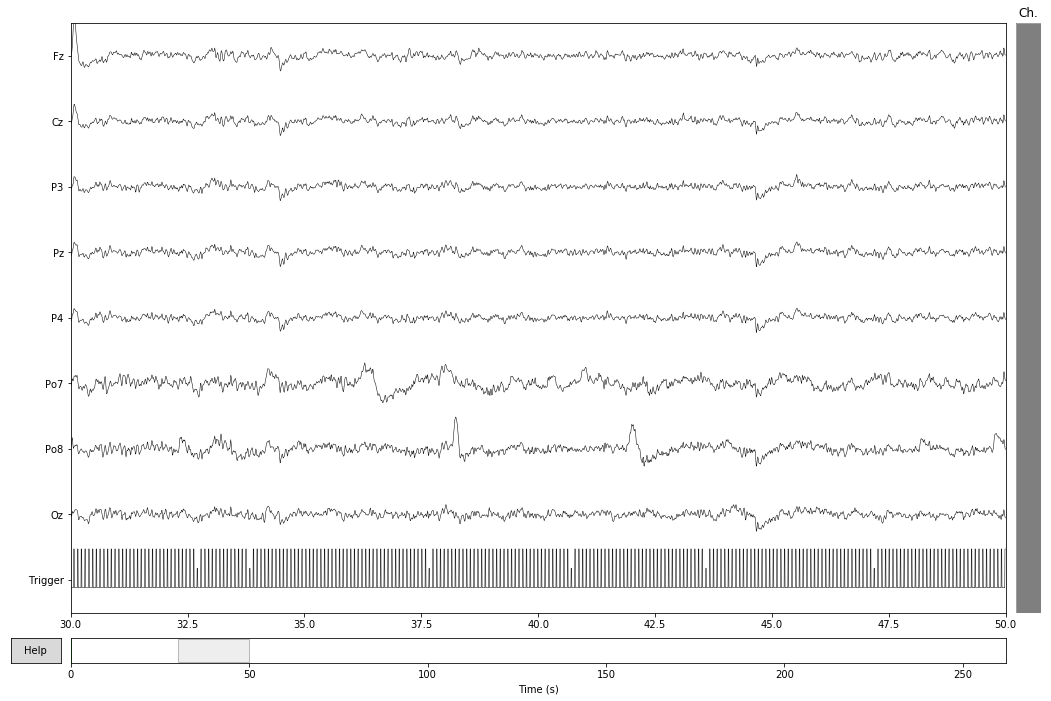

Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.


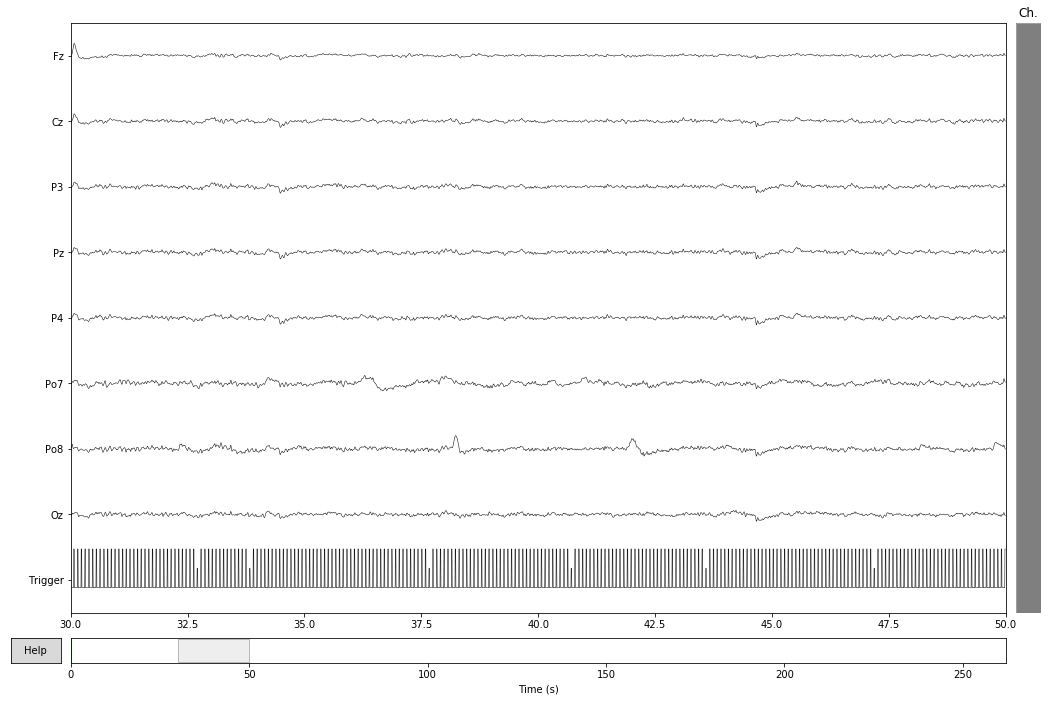

1596 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1596 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



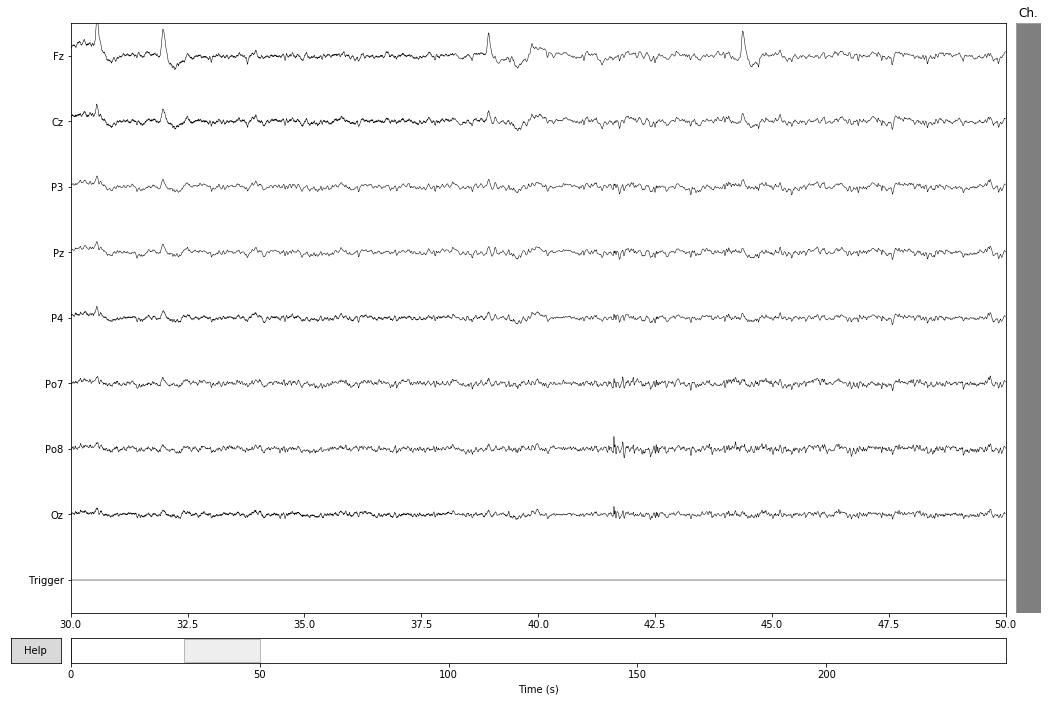

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


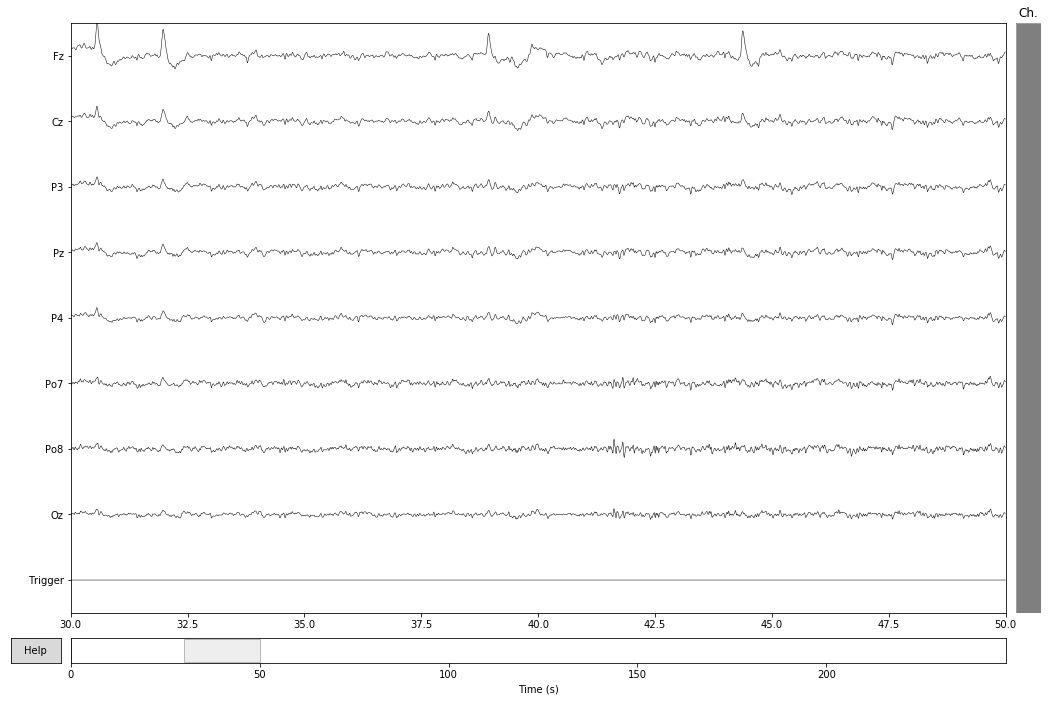

Creating RawArray with float64 data, n_channels=9, n_times=61866
    Range : 0 ... 61865 =      0.000 ...   247.460 secs
Ready.


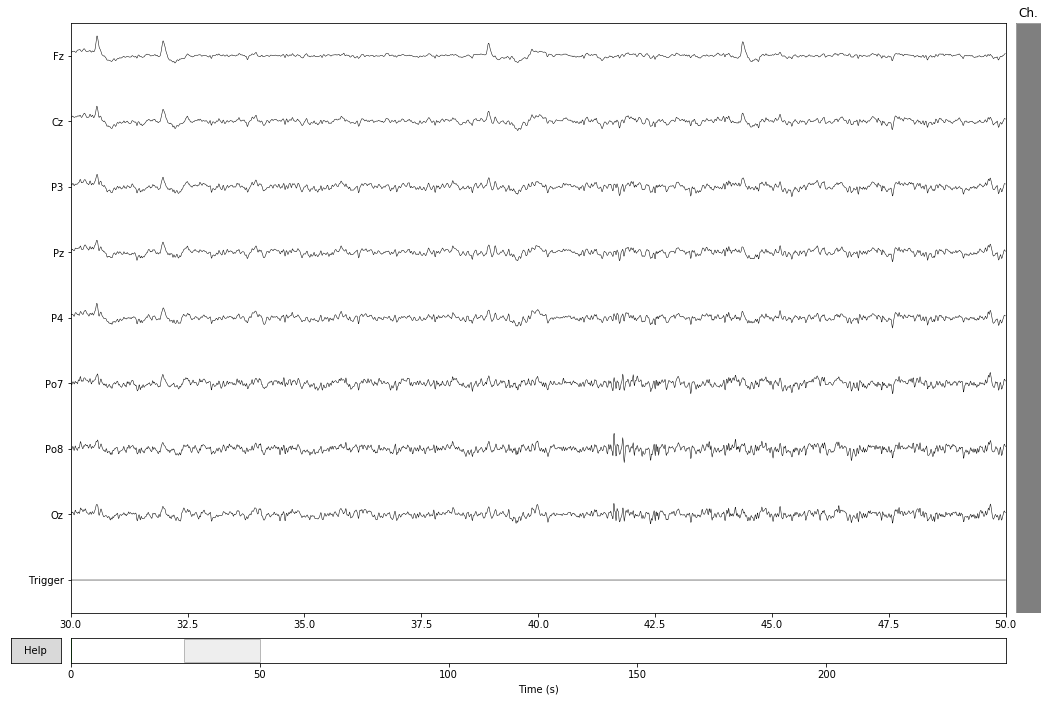

424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 424 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



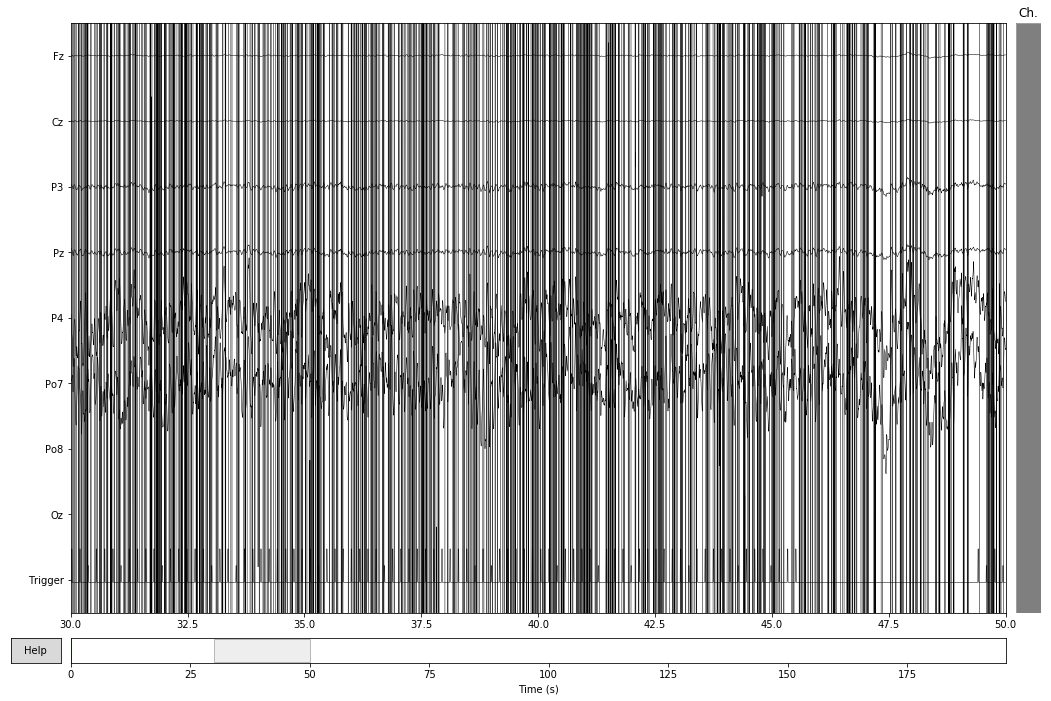

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


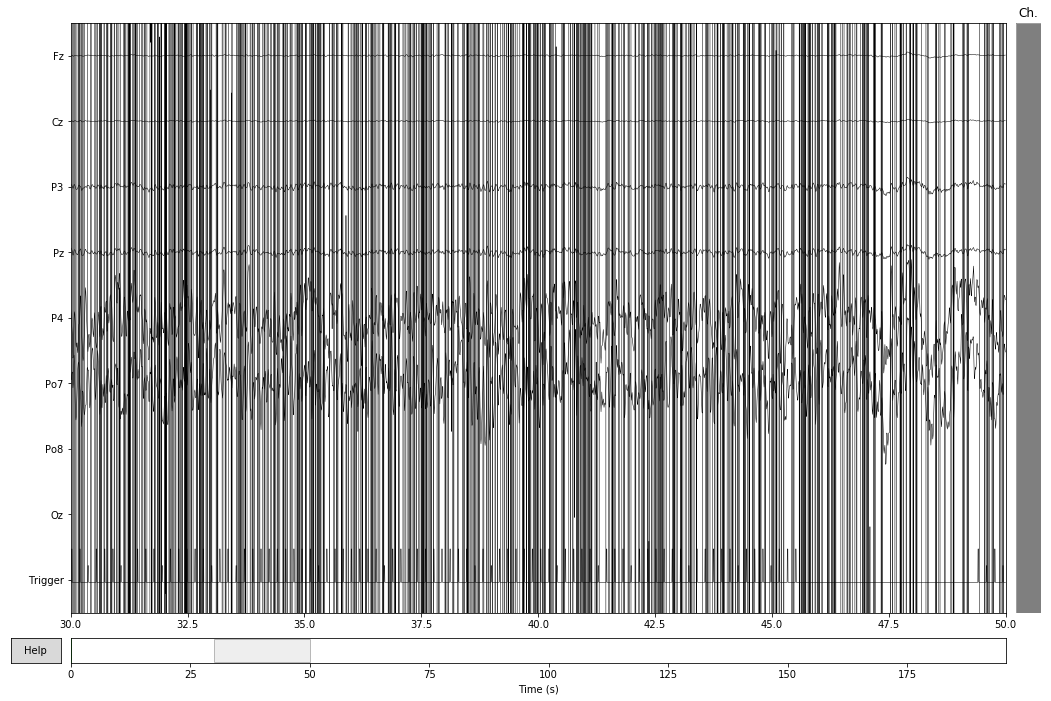

Creating RawArray with float64 data, n_channels=9, n_times=48901
    Range : 0 ... 48900 =      0.000 ...   195.600 secs
Ready.


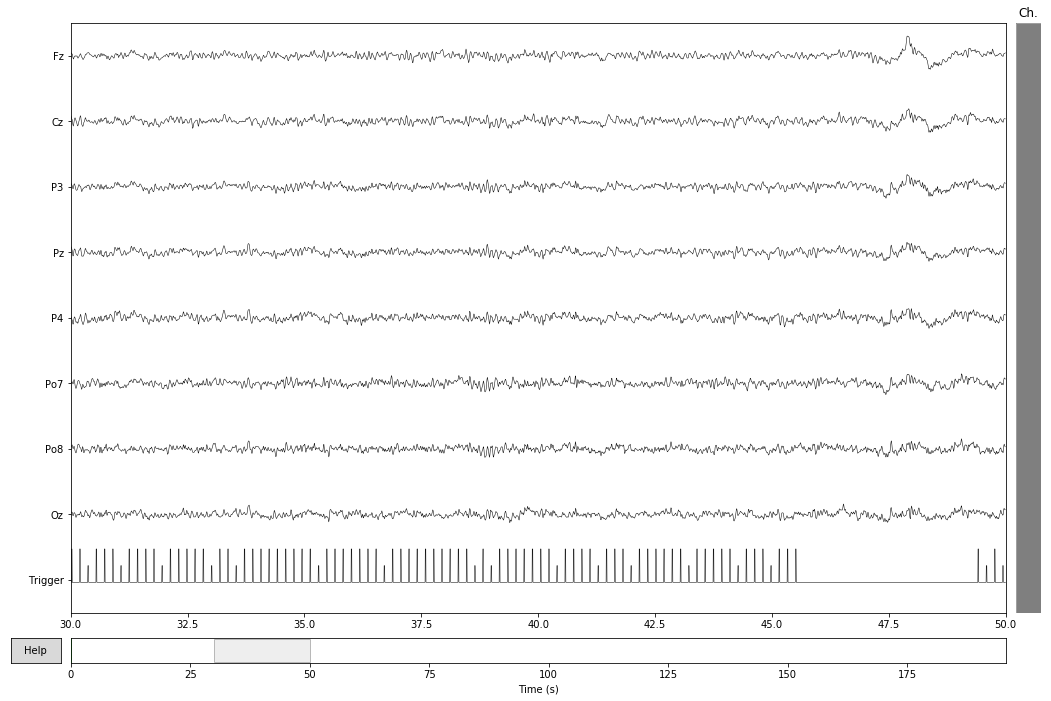

426 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 426 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



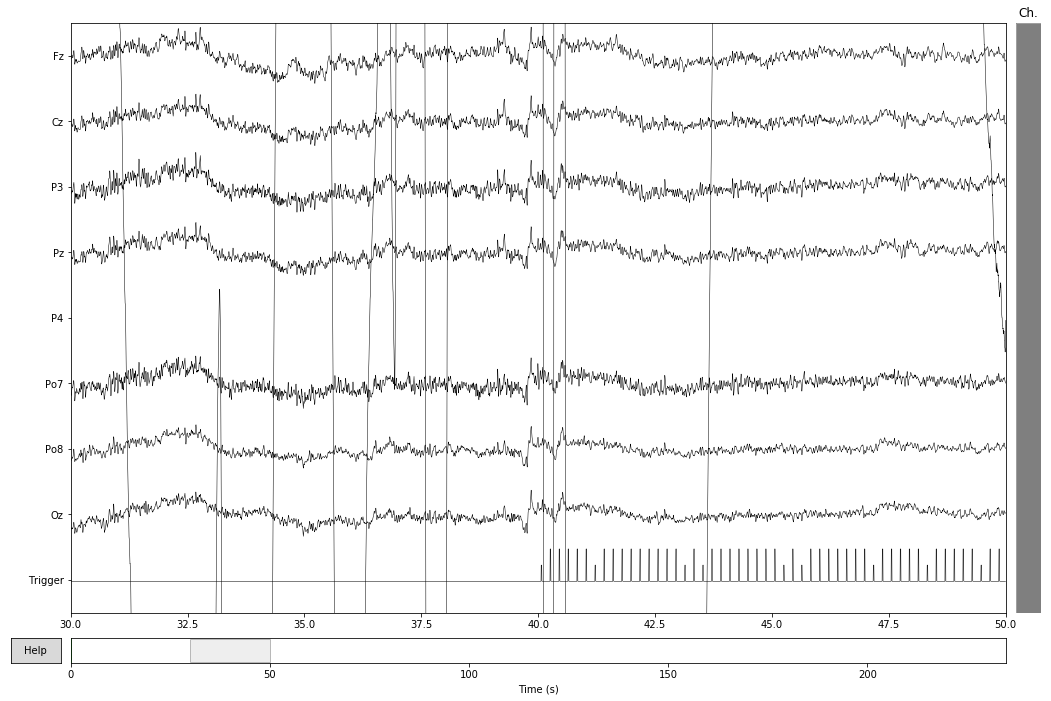

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


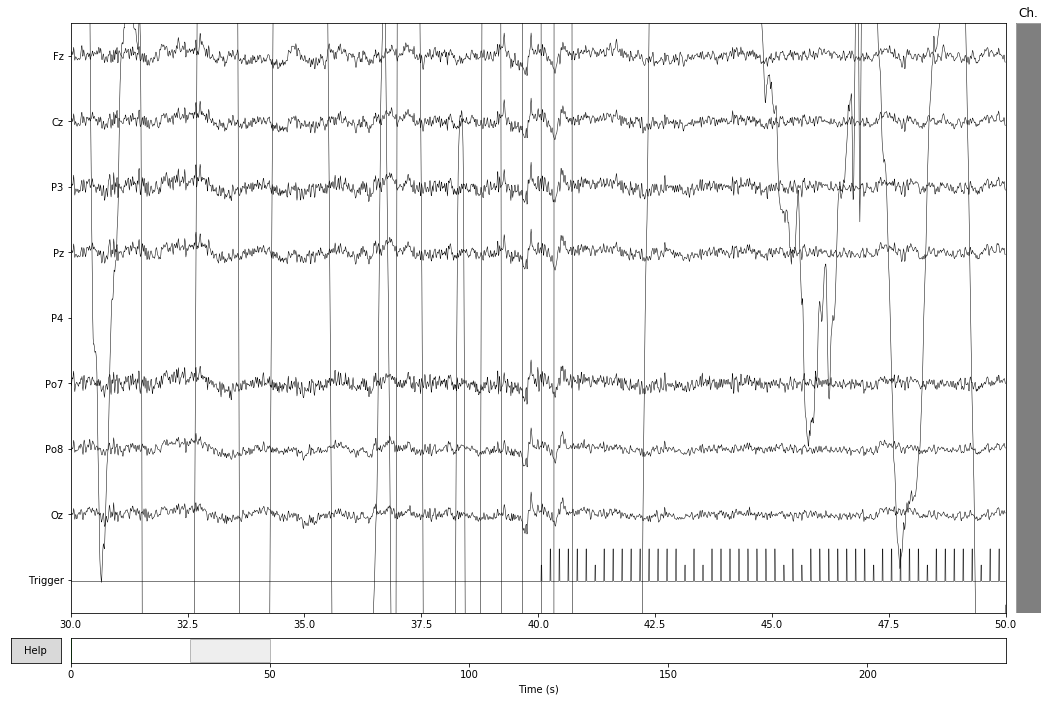

Creating RawArray with float64 data, n_channels=9, n_times=58682
    Range : 0 ... 58681 =      0.000 ...   234.724 secs
Ready.


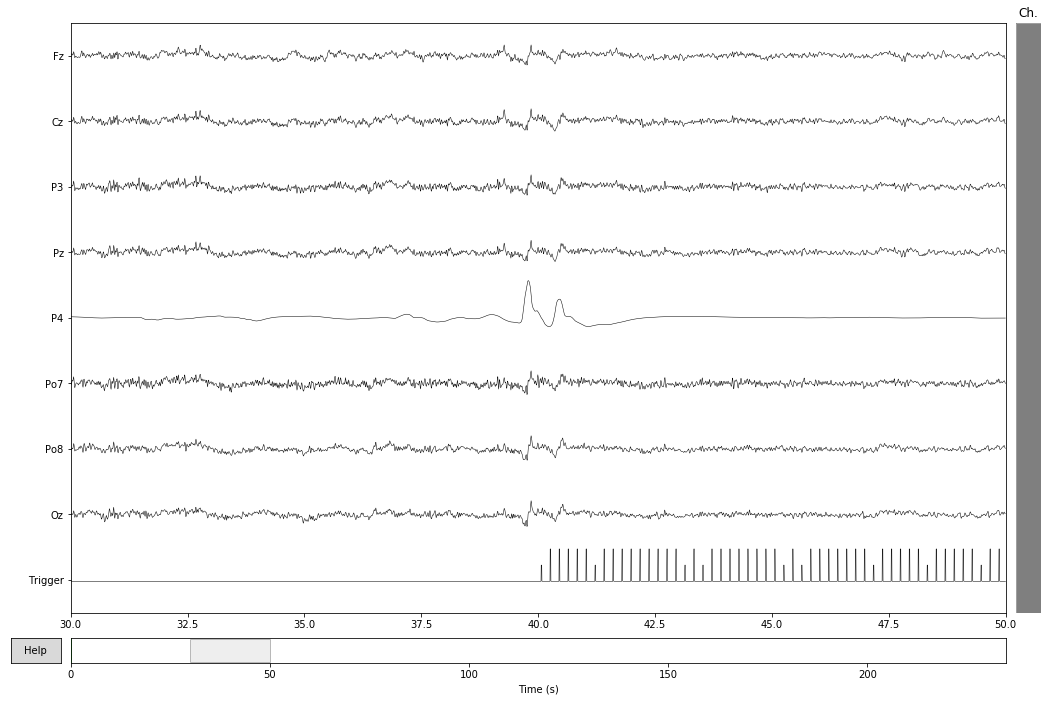

372 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 372 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



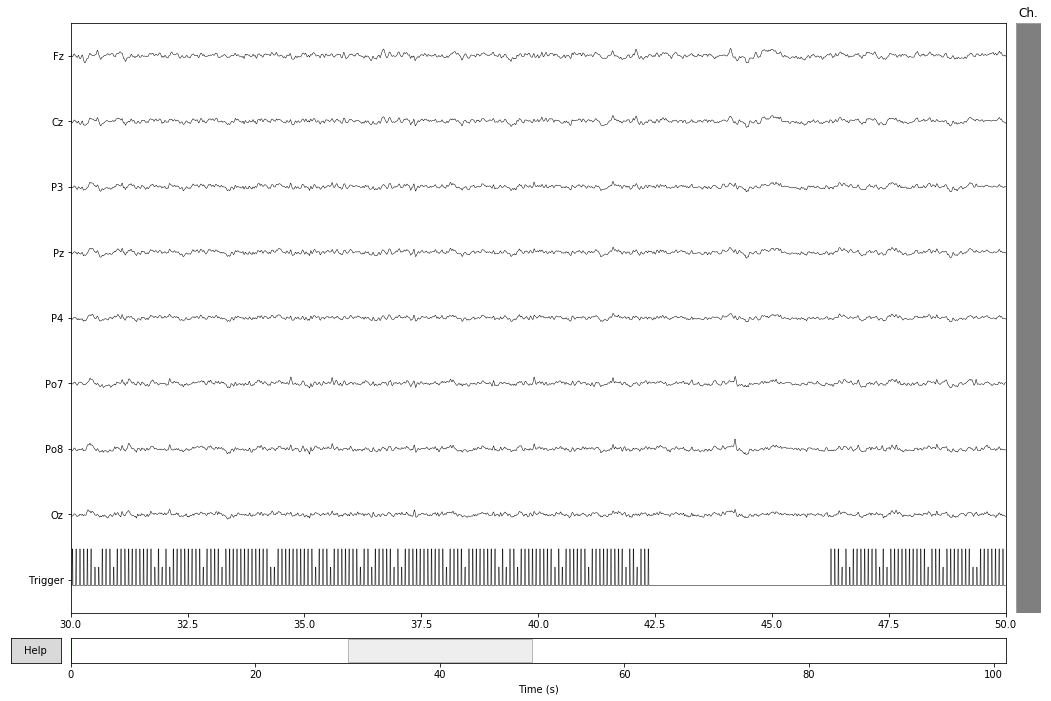

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


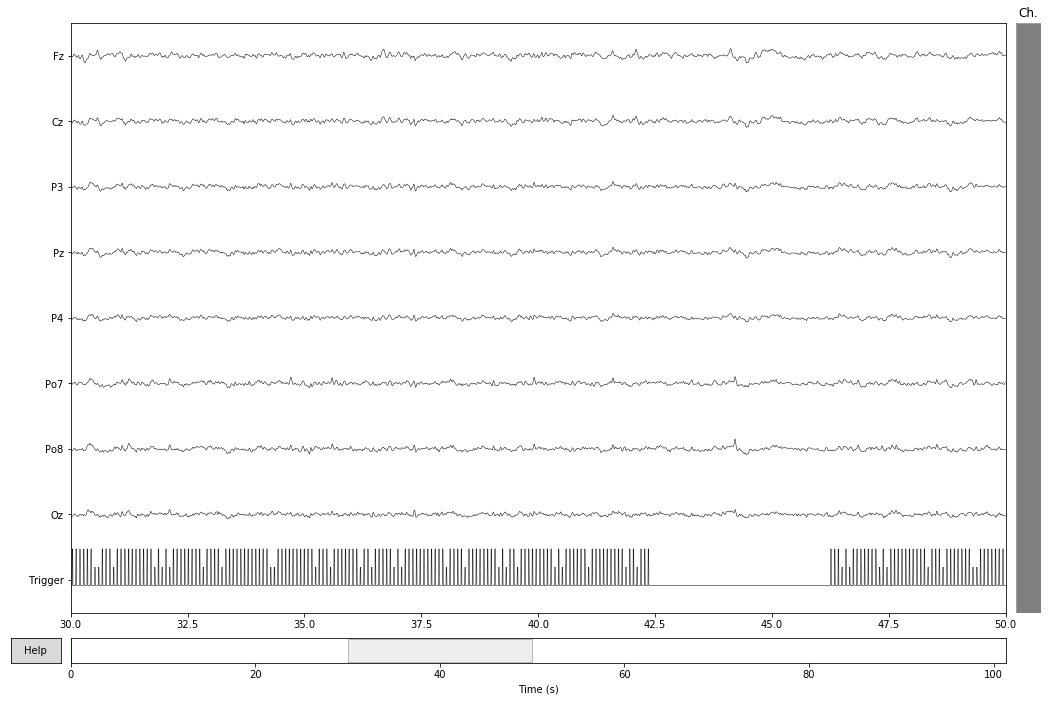

Creating RawArray with float64 data, n_channels=9, n_times=25327
    Range : 0 ... 25326 =      0.000 ...   101.304 secs
Ready.


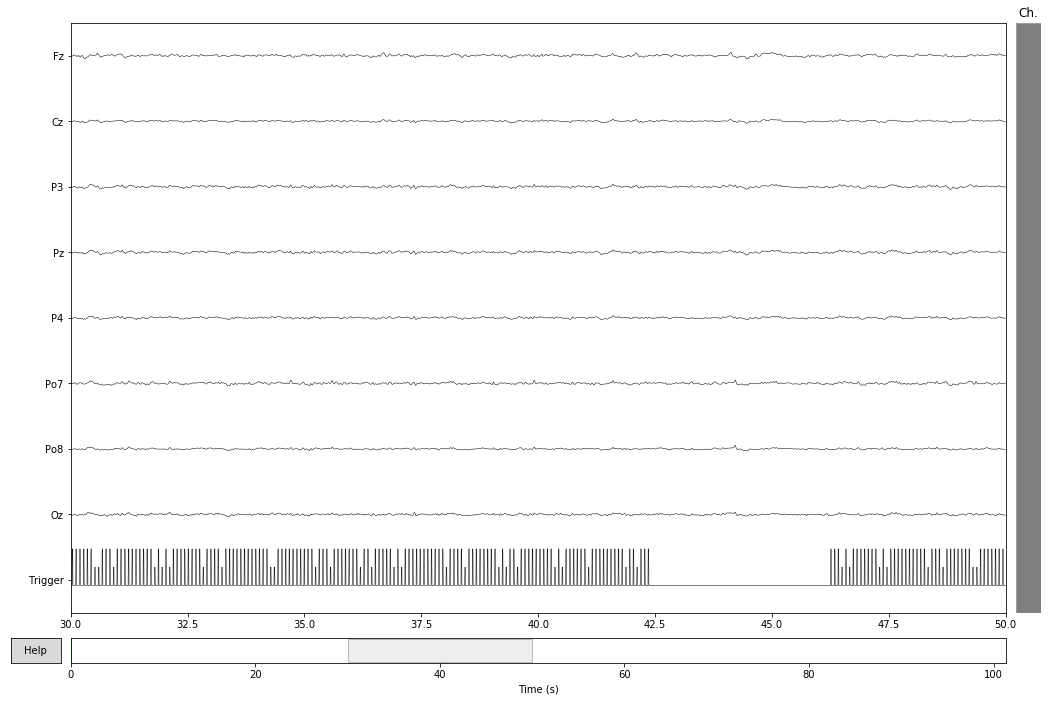

239 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 239 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



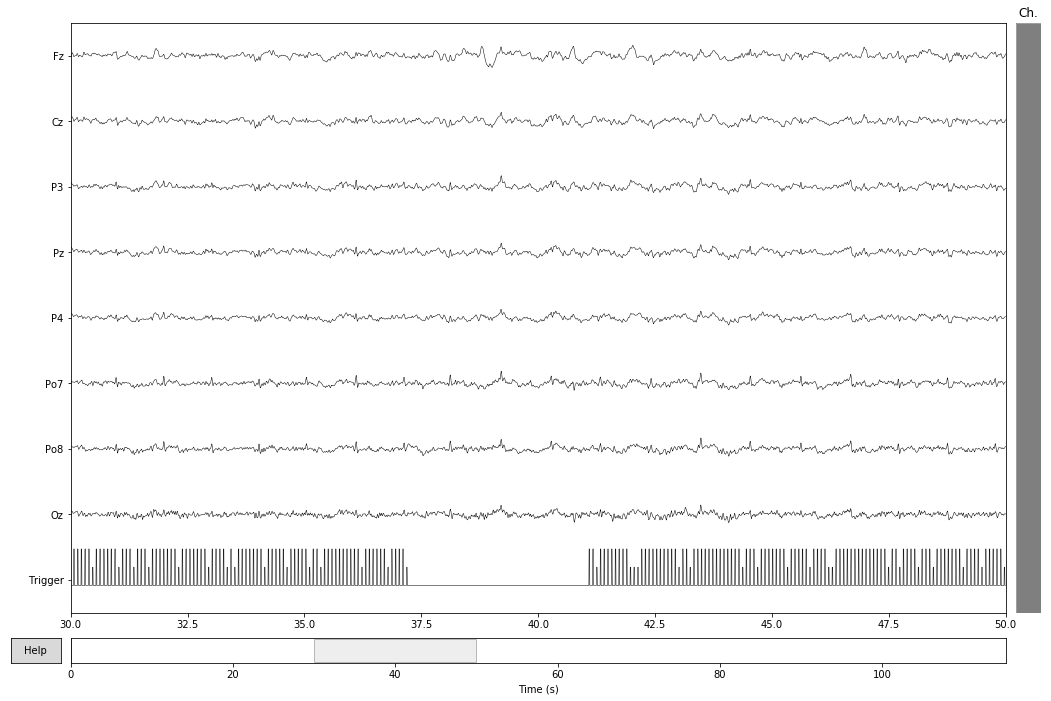

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


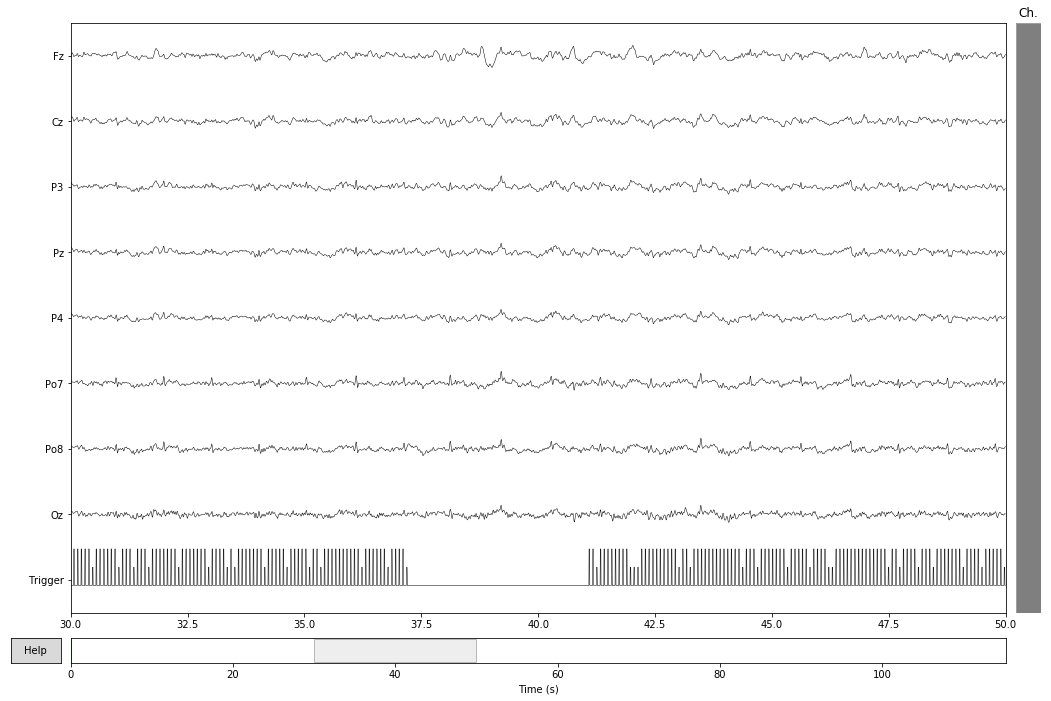

Creating RawArray with float64 data, n_channels=9, n_times=28806
    Range : 0 ... 28805 =      0.000 ...   115.220 secs
Ready.


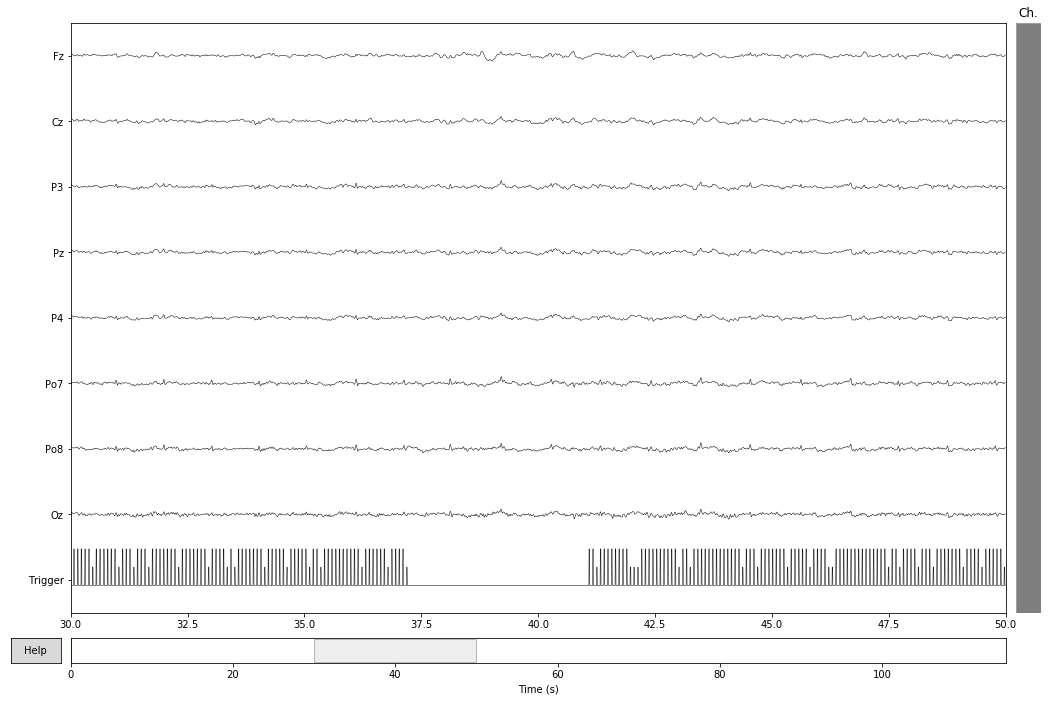

253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



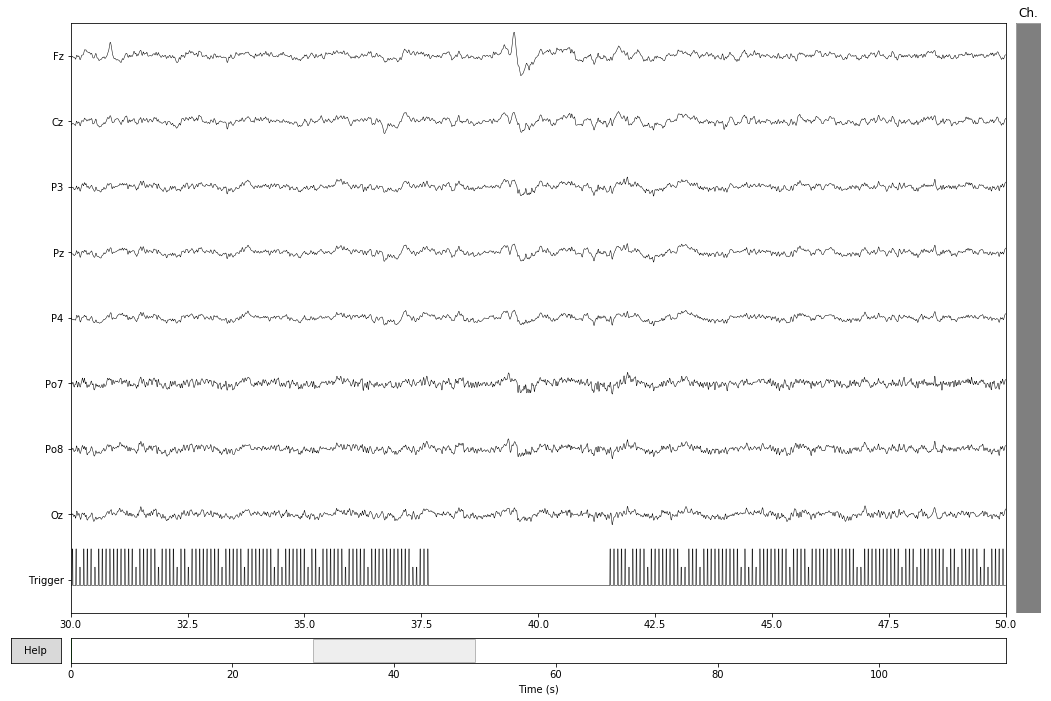

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


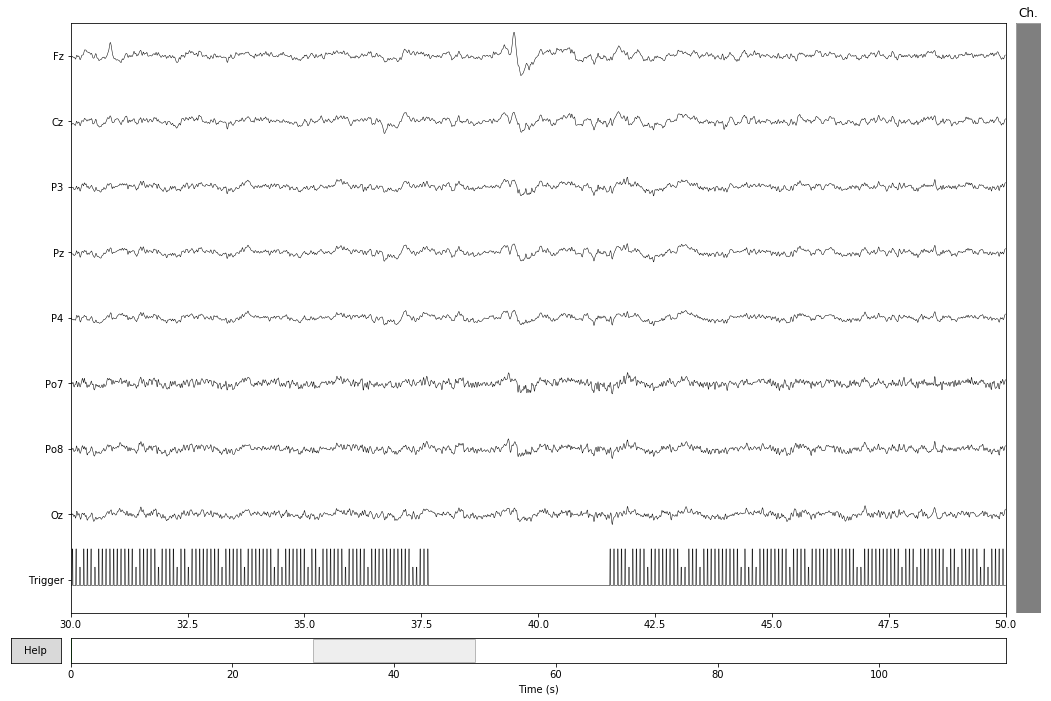

Creating RawArray with float64 data, n_channels=9, n_times=28901
    Range : 0 ... 28900 =      0.000 ...   115.600 secs
Ready.


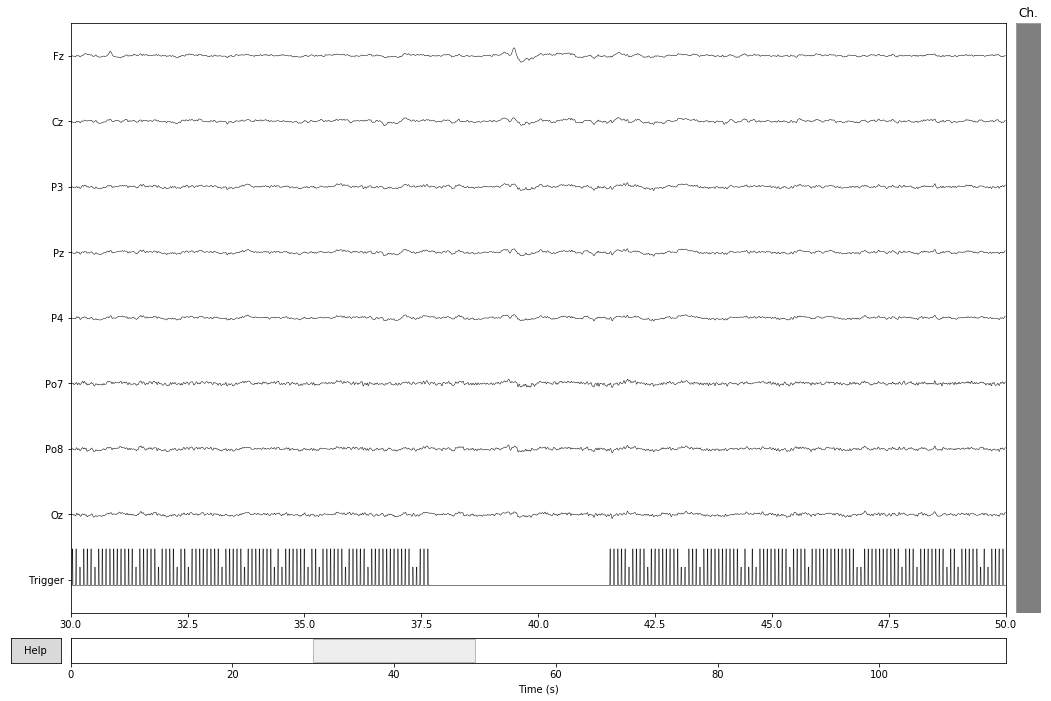

225 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 225 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



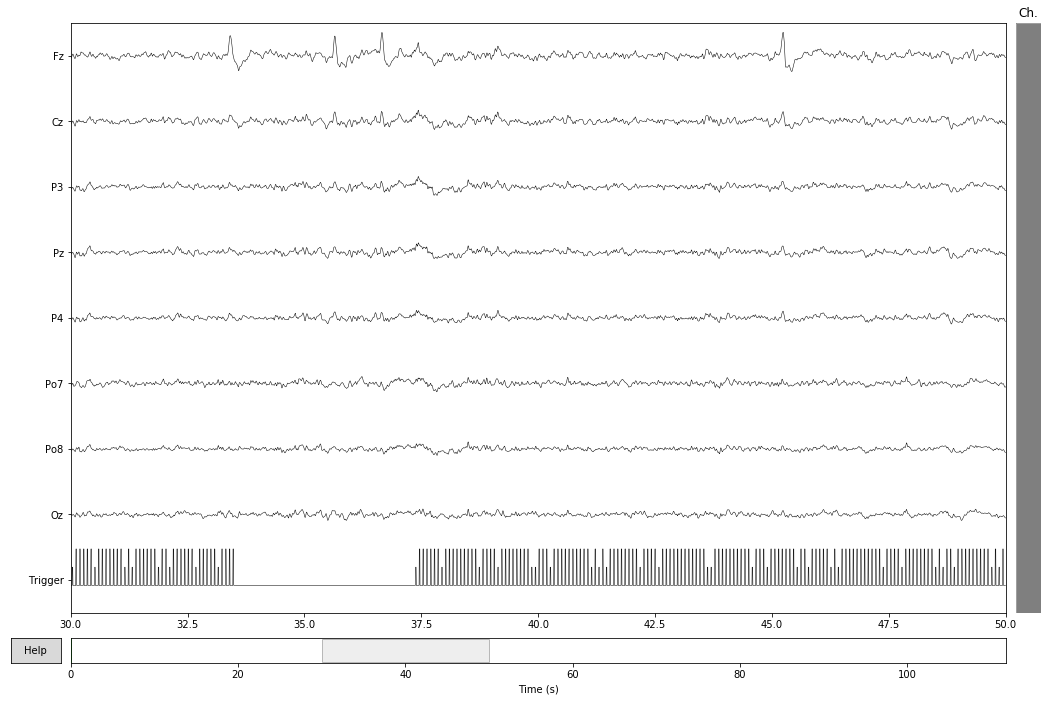

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


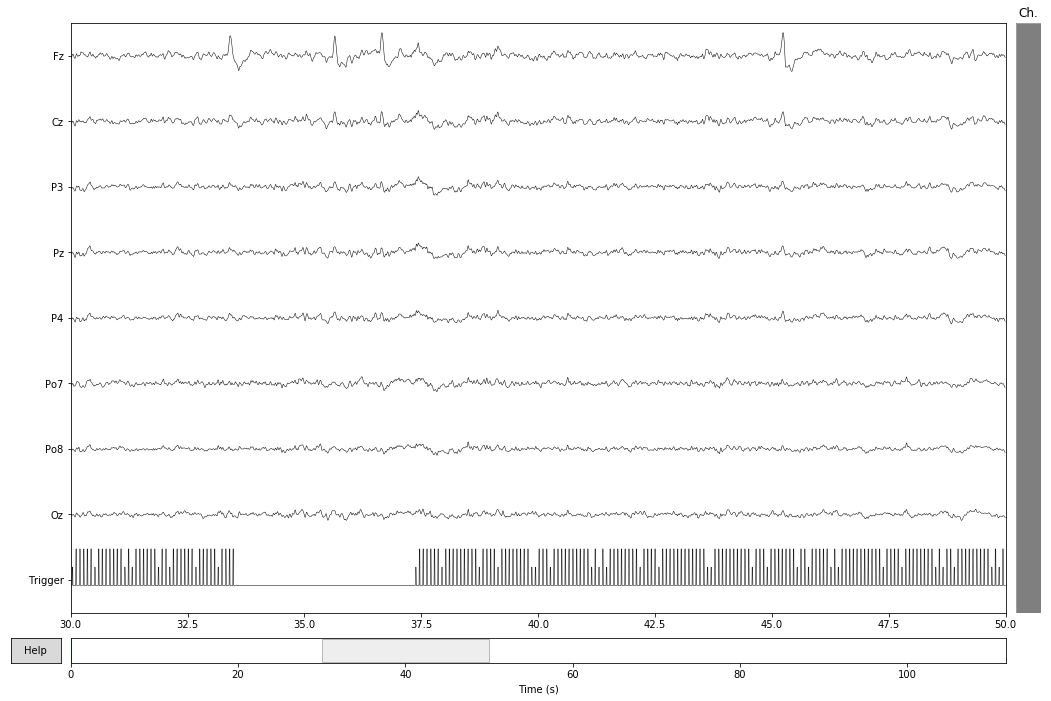

Creating RawArray with float64 data, n_channels=9, n_times=27940
    Range : 0 ... 27939 =      0.000 ...   111.756 secs
Ready.


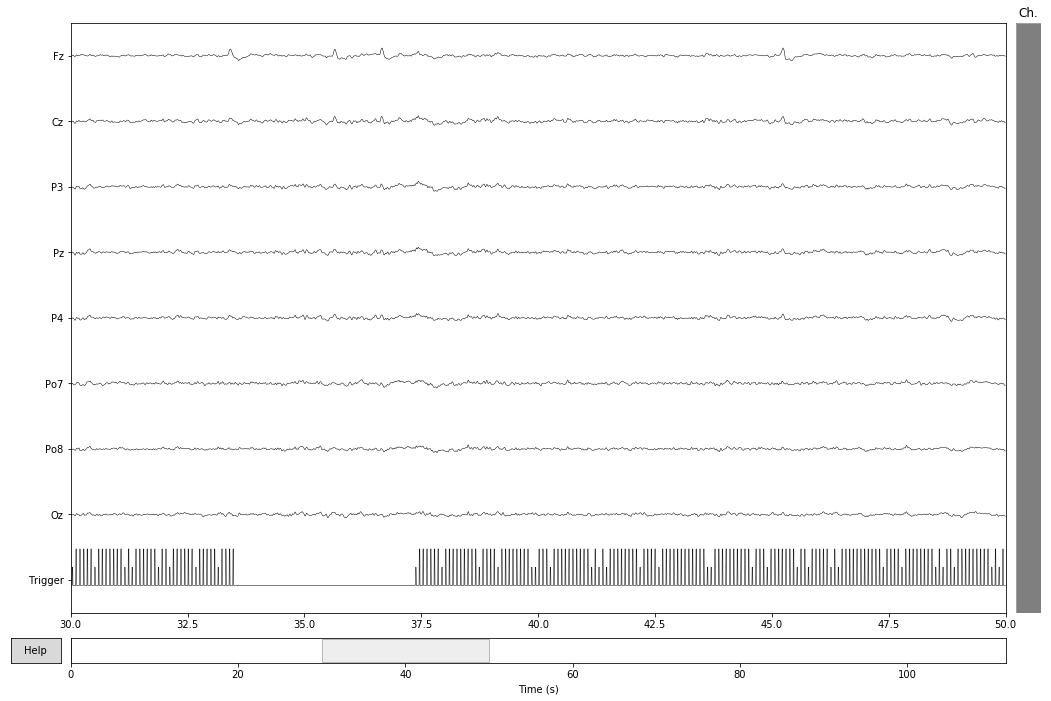

238 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 238 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.

<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



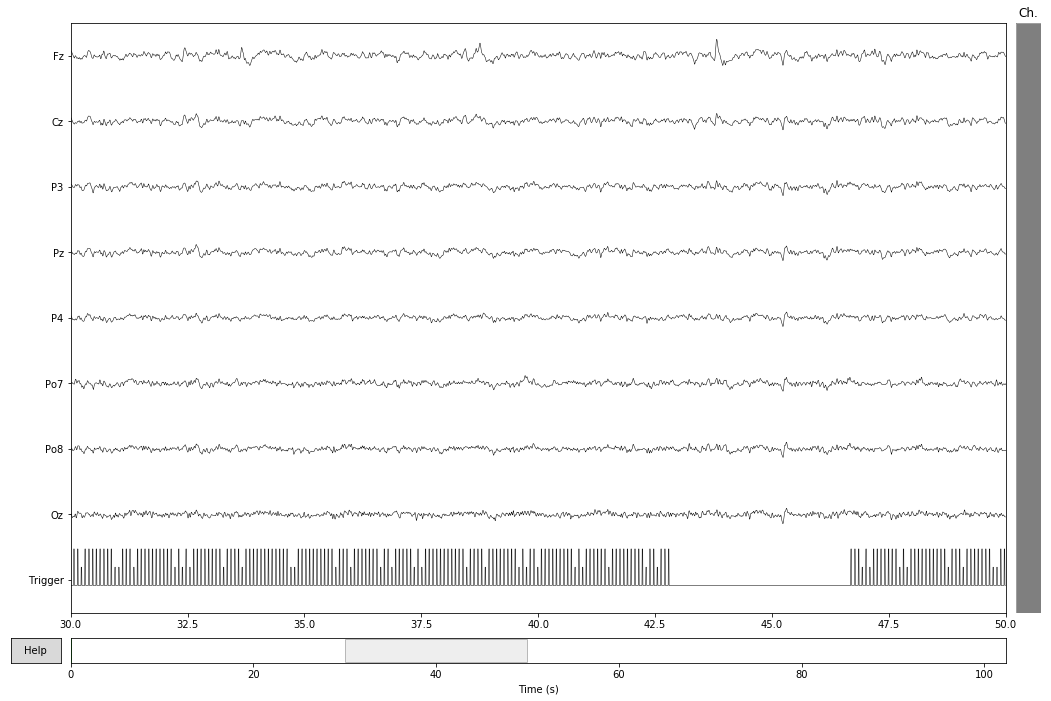

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


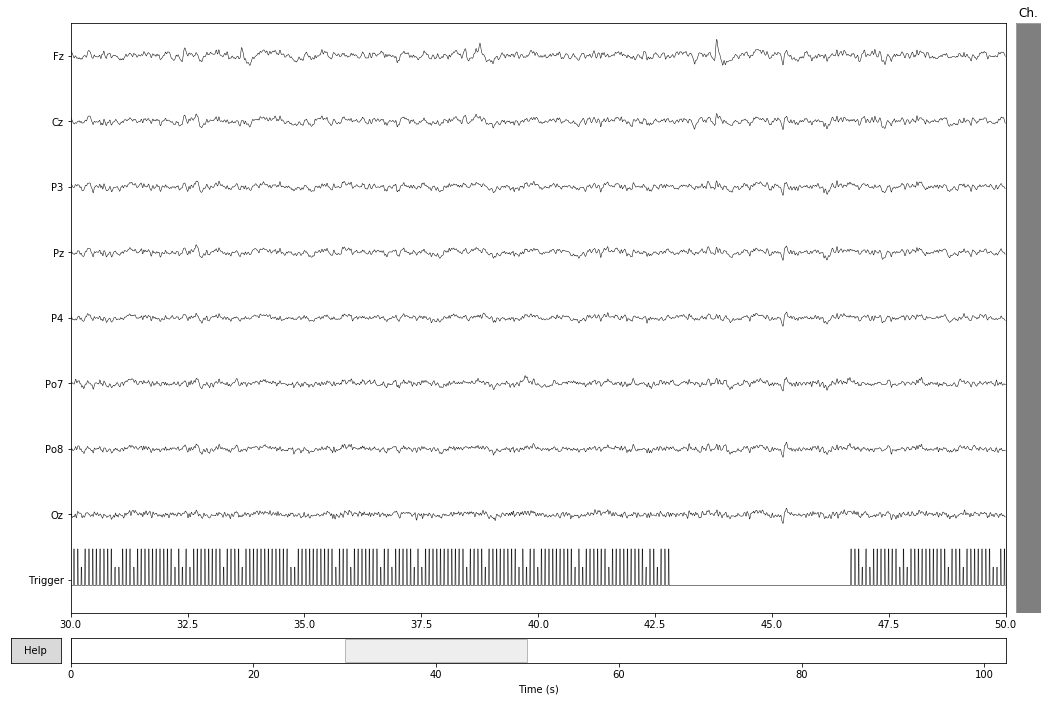

Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.


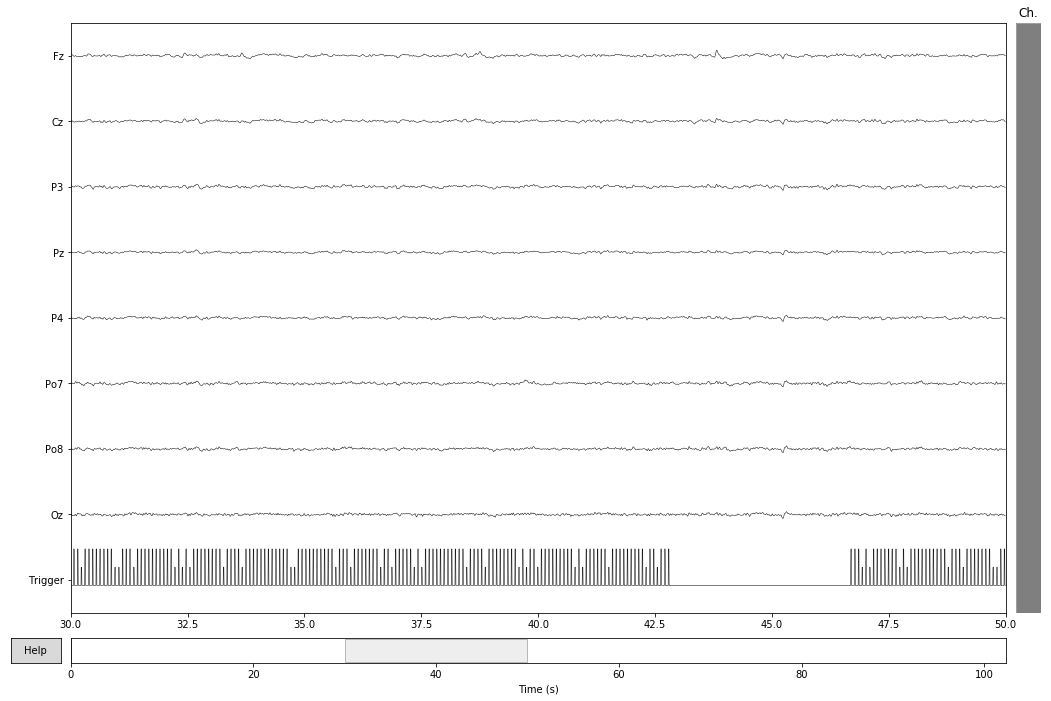

241 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 241 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



In [274]:
all_scores = []
for i in range(1, 11):
    try:
        events_X, events_y = get_dataset(i)
        scores = get_scores(events_X, events_y)
        all_scores += [(i, j, s) for j, s in enumerate(scores)]
    except ValueError:
        pass

In [275]:
scores_df = pd.DataFrame(all_scores, columns=["subject", "trial", "score"])

Bad subjects

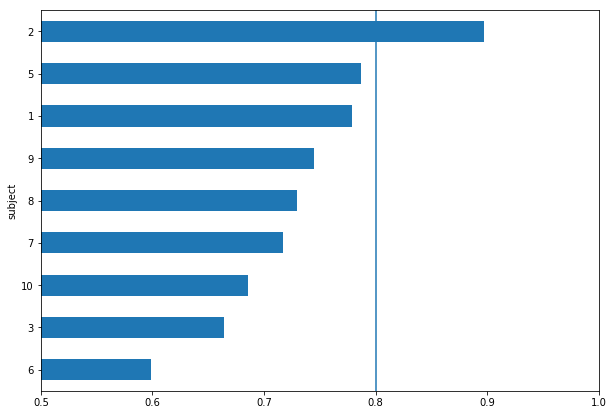

In [276]:
plt.figure(figsize=(10, 7))
scores_df.groupby("subject")["score"].mean().sort_values().plot(kind="barh")
plt.xlim([0.5, 1])
plt.axvline(0.8)

In [277]:
max_trials = scores_df.groupby("subject")["trial"].max()

In [278]:
scores_df["max_trials"] = max_trials[scores_df["subject"]].tolist()

In [279]:
scores_df["trial_normalized"] = scores_df["trial"] / scores_df["max_trials"]

Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
900 events found
Event IDs: [1 2]


<ipython-input-199-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



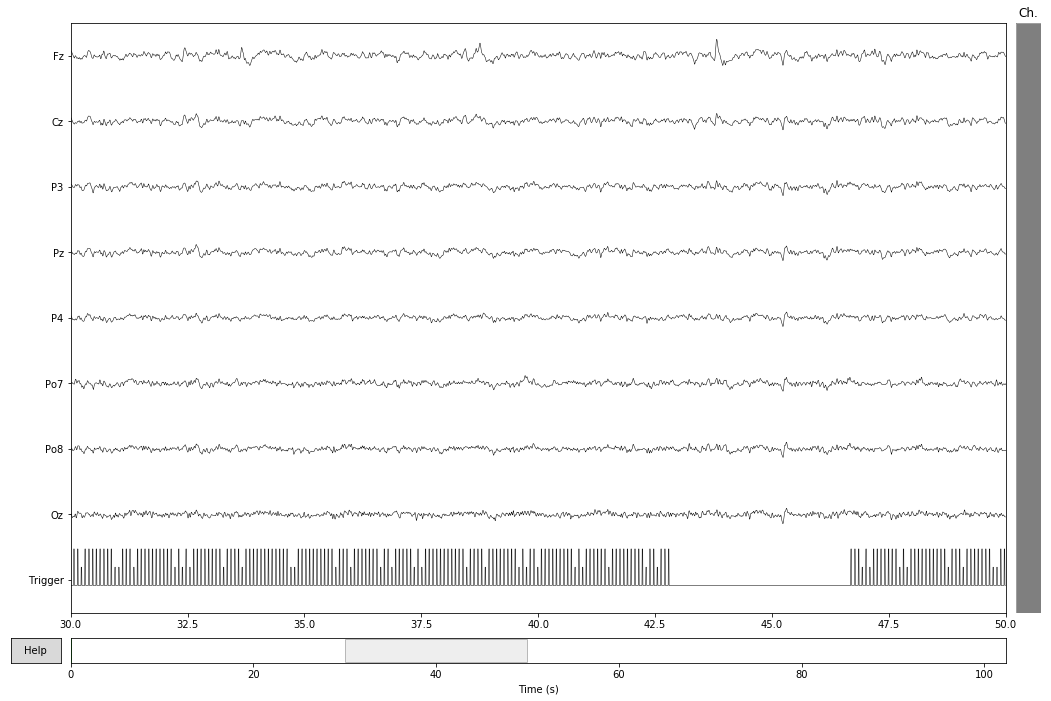

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


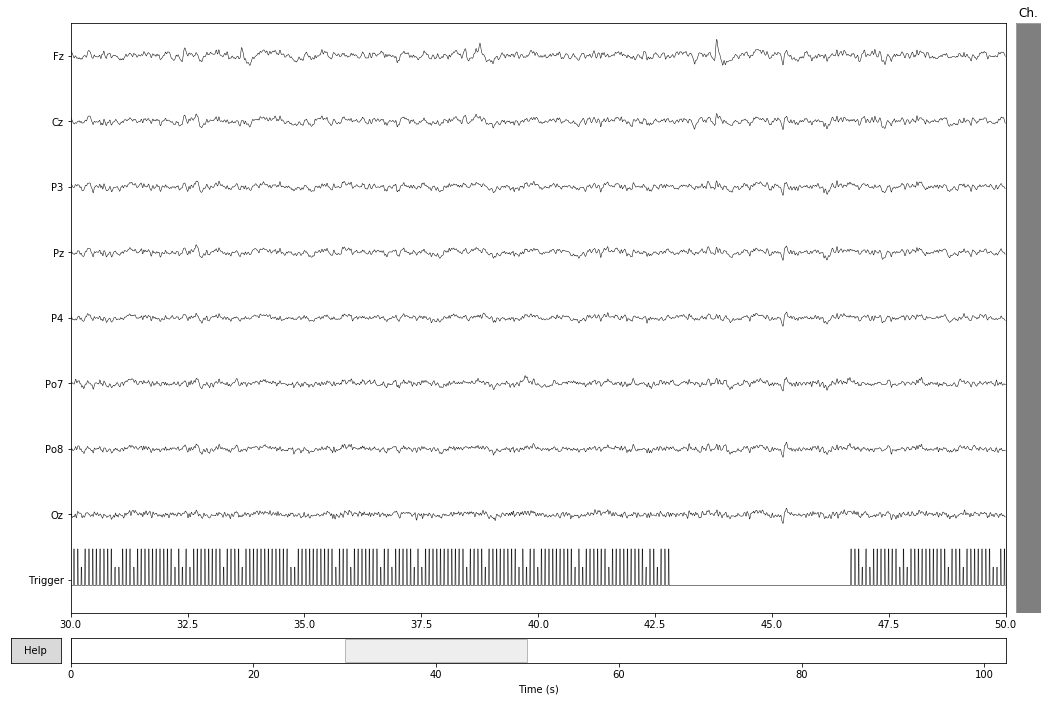

Creating RawArray with float64 data, n_channels=9, n_times=25587
    Range : 0 ... 25586 =      0.000 ...   102.344 secs
Ready.


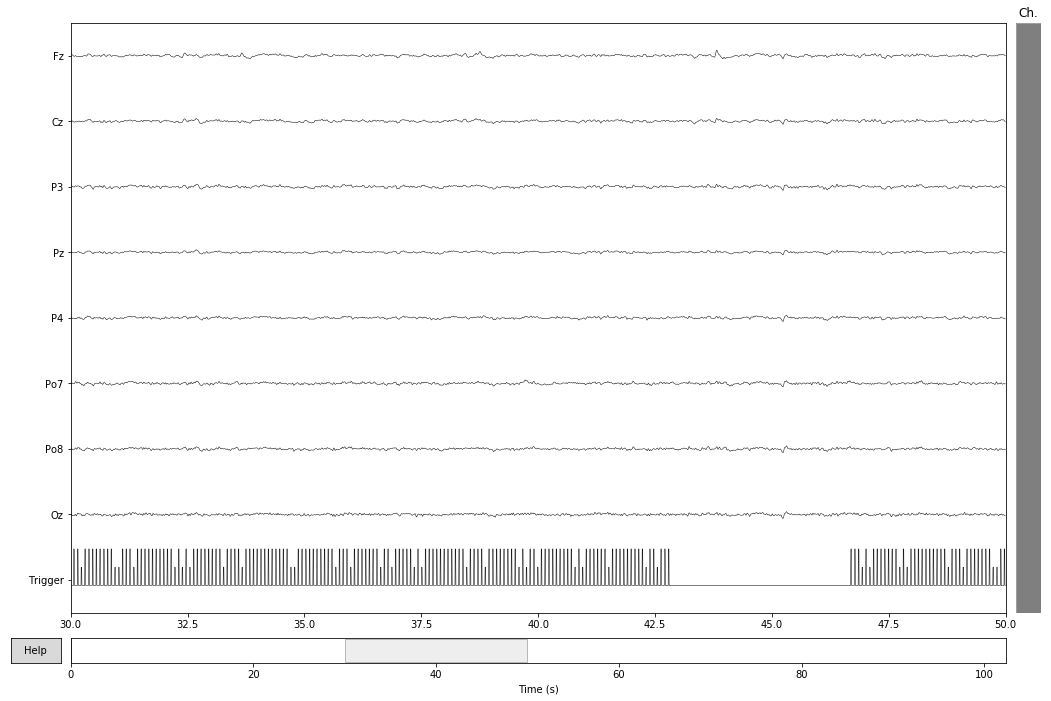

241 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 241 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-265-b8829225ea65>:3: RuntimeWarning:

The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.



In [280]:
events_X, events_y = get_dataset(i)

Good trials

In [160]:
# plt.figure(figsize=(10, 7))
# scores_df[scores_df["subject"].isin([2, 4, 5, 9, 10])].groupby("trial_normalized")["score"].mean().plot()
# plt.axhline(0.8)

Bad trials

In [139]:
subject_scores = scores_df.groupby("subject")["score"].mean()
good_subjects = subject_scores[subject_scores > 0.81].index

In [140]:
good_subjects

Int64Index([2, 4, 5, 8], dtype='int64', name='subject')

In [141]:
good_trials_df = scores_df[scores_df["subject"].isin(good_subjects)]

In [142]:
broken_trials_df = good_trials_df[good_trials_df["score"] < 0.8]

In [143]:
broken_trials_df

subject  trial     score  max_trials  trial_normalized
24        5      0  0.788333           6          0.000000
25        5      1  0.718182           6          0.166667
42        8      1  0.794872           4          0.250000
43        8      2  0.762963           4          0.500000
44        8      3  0.715625           4          0.750000

In [581]:
def process_subject_data(i):
    subject = "S{}".format(i)
    session_df = load_data(subject)
    raw = restore_raw(session_df)
    events = mne.find_events(raw, 'Trigger')
    filter_signal(raw)
    raw = scale_signal(raw, session_df)
    epochs = get_epochs(raw)  
    
    return raw, epochs, events

In [600]:
def visualize_window(raw, epochs, events, attemp, window_size=15):
    epochs['1'][attemp * window_size:(attemp + 1) * window_size].average().plot()
    plt.show()
    window_events = events[events.T[-1] == 1][attemp * 15:(attemp + 1) * 15]
    start_index = window_events.T[0].min()
    stop_index = window_events.T[0].max()
    start = raw.times[start_index]
    stop = raw.times[stop_index]
    plot_raw(raw, start=start, stop=stop, scale=3)

In [604]:
raw, epochs, events = process_subject_data(2)

Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
2700 events found
Event IDs: [1 2]
Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected
2700 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=9, n_times=65502
    Range : 0 ... 65501 =      0.000 ...   262.004 secs
Ready.
2700 events found
Event IDs: [1 2]
2700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2700 events and 201 original time points ...


<ipython-input-22-90a5503e84bc>:10: RuntimeWarning:

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.



0 bad epochs dropped


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-600-af0b9dde981c>:2: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



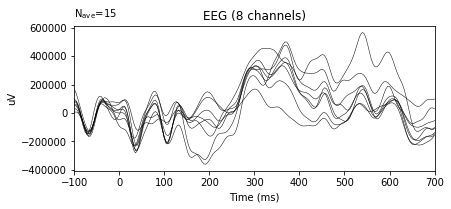

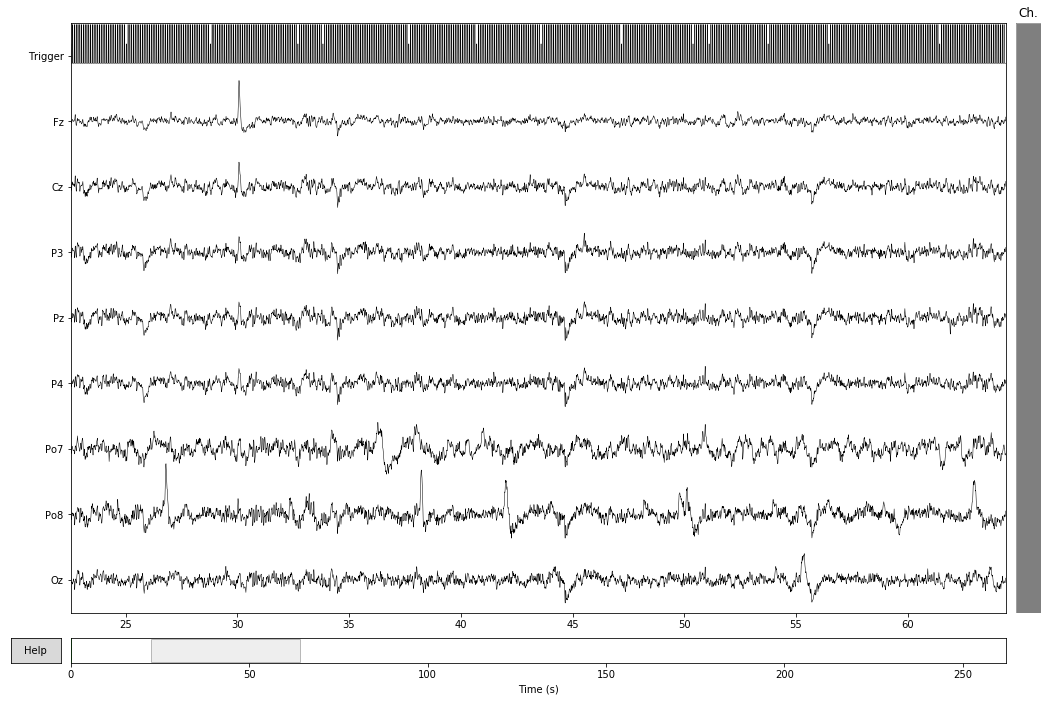

In [605]:
visualize_window(raw, epochs, events, 0)

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-600-af0b9dde981c>:2: DeprecationWarning:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning



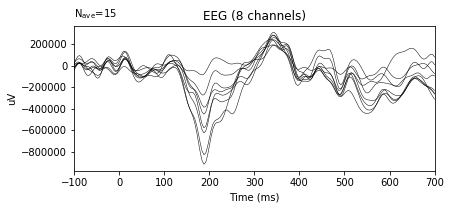

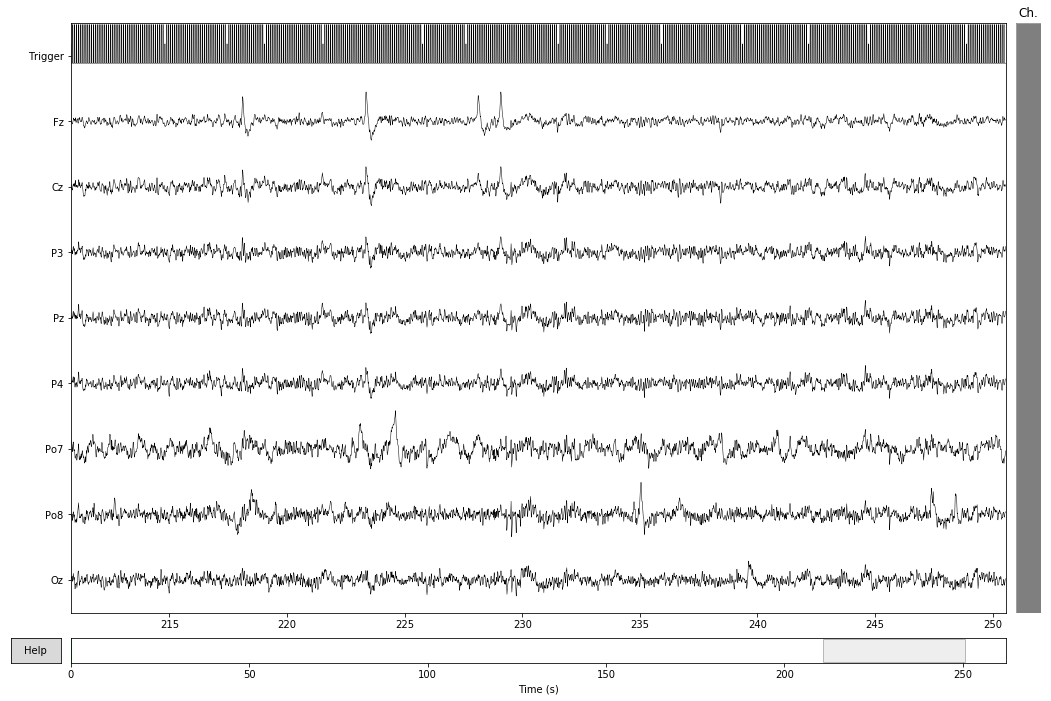

In [609]:
visualize_window(raw, epochs, events, 4)